In [1]:
# 패키지 로드
import os
import numpy as np
import pandas as pd
# import pymysql
import requests
import math
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [2]:
# 라이엇 개발자 페이지에서 게임 상수 최신 버전 정보 가져오기
constant_patch = requests.get('https://ddragon.leagueoflegends.com/api/versions.json').json()[0]

# constant_patch == '11.16.1'

# 라이엇 개발자 페이지에서 최신 버전 한국 서버 아이템 정보 가져오기
item_info = requests.get(f'http://ddragon.leagueoflegends.com/cdn/{constant_patch}/data/ko_KR/item.json').json()

# 라이엇 개발자 페이지에서 최신 버전 한국 서버 챔피언 정보 가져오기
champion_info = requests.get(f'http://ddragon.leagueoflegends.com/cdn/{constant_patch}/data/ko_KR/champion.json').json()

# item_info, champion_info는 json형태

In [3]:
# 챔피언 정보 => DataFrame으로 변환
champion_df = pd.DataFrame(champion_info['data']).T[['key','name']]

# champion_df는 'key'로 id값, 'name'으로 챔피언 한국어 이름을 가지는 156rows짜리 DataFrame

# champion_df의 'key' column string => numeric 변환
champion_df['key'] = pd.to_numeric(champion_df['key'])

In [ ]:
champion_df.info()

In [ ]:
item_info['data']

In [ ]:
print(item_info['data'])

In [ ]:
# for item_id in item_info['data']:
# # print(item_info['data'])
#     print(pd.json_normalize(item_info['data'][item_id]['tags']))

print(pd.json_normalize(item_info['data'][item_id]))

In [ ]:
item_info['data'][item_id]

In [ ]:
pd.json_normalize(item_info['data'][item_id], record_path=['tags']).values

In [4]:
# 아이템 정보 => DataFrame으로 변환
item_df = pd.DataFrame(columns=['id','name','gold'])

# item_df는 아이템의 숫자 id, 한국어 이름(name) 및 조합비(직전 하위템 전부 갖고 있을 때 완성템을 조합할 때 드는 비용)를 가지는 DataFrame

item_tree = pd.DataFrame(columns=['id','id_from'])

# item_tree는 아이템의 숫자 id, 직전 하위템 리스트(id_from)를 가지는 DataFrame
# 예시: 유령 무희(2600G) = 롱소드(350G) + 열정의 검(1050G) + 롱소드(350G) + 850G이므로 유령 무희에 대한 rows가 3개 나옴

for item_id in item_info['data']:
    # Consumable한 아이템(체력 물약 등) 제외
    # 'tags'에 'Consumable' 정보가 없는 아이템에 대해서만 수행
    if 'Consumable' not in pd.json_normalize(item_info['data'][item_id], record_path=['tags']).values:
#     if 'Consumable' not in pd.json_normalize(item_info['data'][item_id]['tags']):
        try:
            # 'consumed' 필드가 있는 아이템( 비스킷 )은 하단 코드가 실행되지 않고 continue로 바로 다음 item_id로 넘어감
            pd.json_normalize(item_info['data'][item_id]).consumed
            continue
        except:
            pass
        
        # 아이템명 및 조합비
        # id, name, gold 3개 필드를 가지게끔 json parsing
        item_row = pd.json_normalize(item_info['data'][item_id])[['name','gold.base']]
        item_row['id'] = item_id
        item_row.rename(columns={'gold.base' : 'gold'}, inplace= True)
        item_df = pd.concat([item_df,item_row])

        # 직전 하위템
        try:
            # 'from' 필드에 있는 항목을 각각 하나의 row로 가지는 item_row_tree DataFrame 생성
            item_row_tree = pd.json_normalize(item_info['data'][item_id], record_path=['from'])
            item_row_tree.rename(columns= {0 : 'id_from'}, inplace = True) 
            item_row_tree['id'] = item_id
            item_tree = pd.concat([item_tree,item_row_tree])
        # 하위템이 없는 경우  생략
        except Exception:
            pass

<ipython-input-4-3a415774a92d>:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'Consumable' not in pd.json_normalize(item_info['data'][item_id], record_path=['tags']).values:


In [ ]:
item_tree_full[item_tree_full['id']== '3046']

In [ ]:
item_tree

In [5]:
item_tree_full = item_tree
item_tree_new = item_tree

# 가장 하위 아이템까지 full 아이템트리 및 각 재료 아이템에 소모되는 골드를 item_tree_full DataFrame에 저장
# 예시로 이 셀 최종 시점에 유령 무희에 대해서는 다음과 같은 rows가 나옴
# id            | id_from          | gold
# 3046(유령 무희) | 3046(유령 무희)    | 850
# 3046(유령 무희) | 3086(열정의 검)    | 150
# 3046(유령 무희) | 1036(롱소드)       | 700
# 3046(유령 무희) | 1018(민첩성의 망토) | 600
# 3046(유령 무희) | 1042(단검)        | 300

while True:
#     item_tree_new에 item_tree를 merge해서 방금 추가한 하위템보다 한 depth 아래의 하위템 리스트 추출
    item_tree_new = item_tree_new.merge(item_tree, left_on= 'id_from', right_on = 'id')[['id_x','id_from_y']].rename(columns = {'id_x':'id','id_from_y': 'id_from'})
    if len(item_tree_new) == 0:
        break
    item_tree_full = pd.concat([item_tree_full, item_tree_new])

# # 자기자신을 리스트에 추가
item_tree_new['id']=item_df['id']
item_tree_new['id_from']=item_df['id']
item_tree_full = pd.concat([item_tree_full, item_tree_new])

# 각 아이템의 조합비를 merge
item_tree_full = item_tree_full.merge(item_df, left_on= 'id_from', right_on='id')[['id_x','id_from','gold']].rename(columns = {'id_x':'id'})
# # 중복되는 row가 발생할 시 gold 수치를 합쳐서 중복되는 row 제거
item_tree_full = item_tree_full.groupby(['id','id_from'], as_index=False).sum('gold')

# 유령 무희 | 롱소드 | 350
# 유령 무희 | 롱소드 | 350
# -->
# 유령 무희 | 롱소드 | 700

In [ ]:
item_tree_full

In [6]:
# string => numeric 형변환
item_df['id'] = pd.to_numeric(item_df['id'])
item_tree_full['id'] = pd.to_numeric(item_tree_full['id'])
item_tree_full['id_from'] = pd.to_numeric(item_tree_full['id_from'])

In [ ]:
item_df.info()

In [7]:
# 메모리 확보를 위해 사용하지 않을 변수 삭제
del constant_patch
del champion_info
del item_id
del item_info
del item_row
del item_row_tree
del item_tree
del item_tree_new

In [ ]:
# # OPGG Database에 connection 생성
# con = pymysql.connect(
#     user = os.environ['LOL_KR_ID'],
#     passwd = os.environ['LOL_KR_PW'],
#     host = os.environ['LOL_KR_HOST'],
#     db = 'lol',
#     charset = 'utf8'
# )
# cursor = con.cursor(pymysql.cursors.DictCursor)

In [ ]:
# # 패치 날짜 데이터 불러오기
# cursor.execute('''
# SELECT version, date
# FROM lolVersionHistory
# ''')
# patchDate = cursor.fetchall()

# patchDate = pd.DataFrame(patchDate)

# # version => season, patch로 가공, 세부 버전(핫픽스, 밸런싱 X 패치 등) 제거
# patchDate['season'] = pd.to_numeric(patchDate['version'].str.split('.').str[0])
# patchDate['patch'] = pd.to_numeric(patchDate['version'].str.split('.').str[1])
# patchDate = patchDate.groupby(['season','patch'],as_index=False).min('date').drop('version', axis = 1).sort_values(['season','patch'])

In [ ]:
# # 현재 패치 칼바람 챔피언&아이템 데이터 불러오기
# cursor.execute('''
# SELECT STRAIGHT_JOIN championId, item0, item1, item2, item3, item4, item5
# FROM opGame o FORCE INDEX (ix_createDate),
# p_opGameStats p FORCE INDEX (`PRIMARY`)
# WHERE o.gameId = p.gameId
# AND o.createDate >= '{lastpatch}'
# AND p.createDate >= '{lastpatch}'
# AND subType = 450
# '''.format(lastpatch=pd.to_datetime(patchDate['date'].tail(1).values[0])))
# gamestats = cursor.fetchall()

# gamestats = pd.DataFrame(gamestats)

# # # csv로 저장
# # gamestats.to_csv("gamestats.csv", mode='w')

In [2]:
# csv 파일에서 가져오기
gamestats = pd.read_csv('data/gamestats.csv', index_col=0)

In [ ]:
champion_df

In [ ]:
item_tree_full

In [3]:
gamestats2 = gamestats.copy()
gamestats2

,gameId,subType,gameLength,teamId,championId,result,position
0,5385587730,440,1804,200,81,WIN,A
1,5385587730,440,1804,200,107,WIN,J
2,5385587730,440,1804,100,121,LOSE,J
3,5385587730,440,1804,100,517,LOSE,M
4,5385587730,440,1804,100,12,LOSE,S
...,...,...,...,...,...,...,...
99995,5385598894,440,1977,200,222,WIN,A
99996,5385598894,440,1977,200,234,WIN,J
99997,5385598894,440,1977,100,81,LOSE,A
99998,5385598894,440,1977,100,1,LOSE,M


In [10]:
# 아이템 컬럼 하나로 모으기
# 'pandas.melt'라는 함수를 적용
# gamestats에 item0 ~ item5로 나와있는 컬럼을 item 컬럼으로 합쳐서 한 소환사당 1*6 형태로 된 DataFrame을 6*1로 변환
itemstats = gamestats2.melt(id_vars='championId', value_name='item').drop(columns='variable')

# itemstats에는 챔피언id가 'championId'로, 구매한 아이템이 'item' column으로 들어감

# 빈 값(0) 지우기
itemstats = itemstats[itemstats.item != 0]

In [11]:
del gamestats
del gamestats2

In [12]:
# 약간 신비한 신발 => 신발 치환
itemstats.item[itemstats.item == 2422] = 1001

# 초시계 시리즈 => 초시계 치환
itemstats.item[itemstats.item.isin([2419, 2421, 2423, 2424])] = 2420

# 무라마나 => 마나무네 치환
# 대천사의 포옹 => 대천사의 지팡이 치환
itemstats.item[itemstats.item == 3042] = 3004
itemstats.item[itemstats.item == 3040] = 3003

# 오른의 걸작 치환
itemstats.item[itemstats.item == 7000] = 6693
itemstats.item[itemstats.item == 7001] = 6692
itemstats.item[itemstats.item == 7002] = 6691
itemstats.item[itemstats.item == 7003] = 6664
itemstats.item[itemstats.item == 7004] = 3068
itemstats.item[itemstats.item == 7005] = 6662
itemstats.item[itemstats.item == 7006] = 6671
itemstats.item[itemstats.item == 7007] = 6672
itemstats.item[itemstats.item == 7008] = 6673
itemstats.item[itemstats.item == 7009] = 4633
itemstats.item[itemstats.item == 7010] = 4636
itemstats.item[itemstats.item == 7011] = 3152
itemstats.item[itemstats.item == 7012] = 6653
itemstats.item[itemstats.item == 7013] = 6655
itemstats.item[itemstats.item == 7014] = 6656
itemstats.item[itemstats.item == 7015] = 6630
itemstats.item[itemstats.item == 7016] = 6631
itemstats.item[itemstats.item == 7017] = 6632
itemstats.item[itemstats.item == 7018] = 3078
itemstats.item[itemstats.item == 7019] = 3190
itemstats.item[itemstats.item == 7020] = 2065
itemstats.item[itemstats.item == 7021] = 6617
itemstats.item[itemstats.item == 7022] = 4005

In [60]:
itemstats2 = itemstats.copy()
itemstats2

,championId,item
0,43,6653
1,517,2420
2,122,6630
3,80,2031
4,7,1026
...,...,...
76200955,110,3004
76200956,84,3067
76200957,234,1036
76200958,429,1053


In [61]:
# 챔피언별로 각 아이템에 투자한 골드 총량 계산

# championId, item를 기준으로 grouping하여 row 수를 'size' column을 만들어 저장
# itemstats2['size'] = 1
# itemstats2 = itemstats2.groupby(by=['championId','item']).sum()
# itemstats2 = itemstats2.reset_index()
itemstats2 = itemstats2.groupby(['championId','item'], as_index=False).size()

# item_tree_full과 merge하여 각 아이템에 맵핑되는 조합비(gold) column 추가
itemstats2 = itemstats2.merge(item_tree_full, how = 'inner', left_on='item', right_on='id').drop(columns='item')
# itemstats = itemstats.merge(item_tree_full, left_on= 'item', right_on='id')[['chmapionId','id_from','size','gold']]

# 해당 아이템의 조합비가 적혀 있는 'gold' column에 해당 아이템을 사는데 소모한 총 골드(gold * size) 덮어쓰기
itemstats2['gold'] = itemstats2['gold'] * itemstats2['size']

# 이후 계산 알아보기 쉽도록 scaling
# Consine similarity를 쓰기 때문에 value scaling은 영향 없음
itemstats2['gold'] = itemstats2['gold'] / 1e5

# size column 제거
itemstats2 = itemstats2.drop('size',axis=1)

# item_tree_full과 merge할 때 생긴 중복 row 합치기
itemstats2 = itemstats2.groupby(['championId','id_from'],as_index=False).apply(lambda x: pd.Series({'gold':
                                                                                         sum(x.gold)}))

In [62]:
itemstats2

,championId,id_from,gold
0,1,1001,218.1090
1,1,1004,3.8825
2,1,1006,1.3665
3,1,1011,54.4700
4,1,1018,6.7380
...,...,...,...
22676,887,6692,0.0255
22677,887,6693,0.0200
22678,887,6694,0.0130
22679,887,6695,0.0625


In [63]:
# 챔피언 골드 비례 상수 계산
championstats = itemstats2.groupby('championId',as_index=False).apply(lambda x: pd.Series({'length':
                                                                                         math.sqrt(sum(x.gold**2))}))

In [42]:
#itemstats2 = itemstats2.merge(itemstats2 , on='id_from')[['championId_x','championId_y','gold_x','gold_y']]
# itemstats2 = itemstats2[itemstats2['gold_x'] > itemstats2['gold_y']]
# itemstats2['gold_prod'] = itemstats2['gold_x'] * itemstats2['gold_y']

# itemstats2 = itemstats2.drop(['gold_x','gold_y'],axis=1)
# itemstats2

In [64]:
# 각 챔피언 간 유사도 계산을 위한 내적(inner product) 계산 수행

# itemstats 자기자신을 아이템 기준으로 merge하여 champion X와 champion Y가 해당 아이템을 사는데 소모한 골드를 한 row에 저장
itemstats2 = itemstats2.merge(itemstats2 , on='id_from')[['championId_x','championId_y','gold_x','gold_y']]
# itemstats == [championId_x | championId_y | gold_x | gold_y]

# championId_x > championId_y인 row만 남기기
itemstats2 = itemstats2[itemstats2['championId_x'] > itemstats2['championId_y']]

# 각 row에 대해 gold_x와 gold_y를 곱해서 gold_prod 컬럼에 저장
itemstats2['gold_prod'] = itemstats2['gold_x'] * itemstats2['gold_y']

# 다 사용한 gold columns 제거
itemstats2 = itemstats2.drop(['gold_x','gold_y'],axis=1)

# championId_x, championId_y를 기준으로 grouping하여 gold_prod 합 계산
itemstats2 = itemstats2.groupby(['championId_x','championId_y']).sum().reset_index()
# itemstats2 = itemstats2.groupby(['championId_x','championId_y'], as_index=False).apply(lambda x: pd.Series({'gold_prod' :sum(x.gold_prod)}))
# itemstats == [championId_x | championId_y | gold_prod]

In [44]:
itemstats2

,championId_x,championId_y,gold_prod
0,2,1,1.556730e+05
1,3,1,1.550968e+06
2,3,2,5.182713e+05
3,4,1,7.096273e+06
4,4,2,3.250152e+05
...,...,...,...
12085,887,526,2.063231e+05
12086,887,555,3.964452e+05
12087,887,777,2.452904e+05
12088,887,875,1.136604e+06


In [65]:
# 챔피언 유사도 및 거리 계산

# itemstats에 championstats를 merge해서 length_x, length_y 컬럼 추가
itemstats2 = itemstats2.merge(championstats,left_on='championId_x', right_on='championId').rename(columns={'length':'length_x'}).drop(columns='championId')
itemstats2 = itemstats2.merge(championstats,left_on='championId_y', right_on='championId').rename(columns={'length':'length_y'}).drop(columns='championId')
# itemstats == [championId_x | championId_y | gold_prod | length_x | length_y]

# similarity = gold_prod / (length_x * length_y) column 추가
itemstats2['similarity'] = itemstats2['gold_prod'] / (itemstats2['length_x'] * itemstats2['length_y']) 

# distance = arccos(similarity)/(pi/2) column 추가
itemstats2['distance'] = np.arccos(itemstats2['similarity']) / (np.pi/2)

# 필요한 column(챔피언간 거리)만 추출
itemstats2 = itemstats2[['championId_x','championId_y','distance']]

In [67]:
itemstats2

,championId_x,championId_y,distance
0,2,1,0.931836
1,3,1,0.720337
2,4,1,0.339766
3,5,1,0.938568
4,6,1,0.930321
...,...,...,...
12085,876,777,0.987580
12086,887,777,0.956487
12087,876,875,0.868498
12088,887,875,0.822705


In [68]:
# distance array 형태로 변환
# index에 주의

# itemstats를 championId_x, championId_y 내림차순으로 정렬하여 'distance' column만 남겨두기
distance_array = itemstats2.sort_values(['championId_x','championId_y'], ascending=[False,False])['distance']

In [69]:
distance_array

12089    0.417589
12088    0.822705
12086    0.956487
12083    0.974986
12079    0.788218
           ...   
156      0.896831
2        0.339766
155      0.604904
1        0.720337
0        0.931836
Name: distance, Length: 12090, dtype: float64

In [70]:
# 'complete' 메소드로 h-clustering 수행
Z = linkage(distance_array, 'complete')

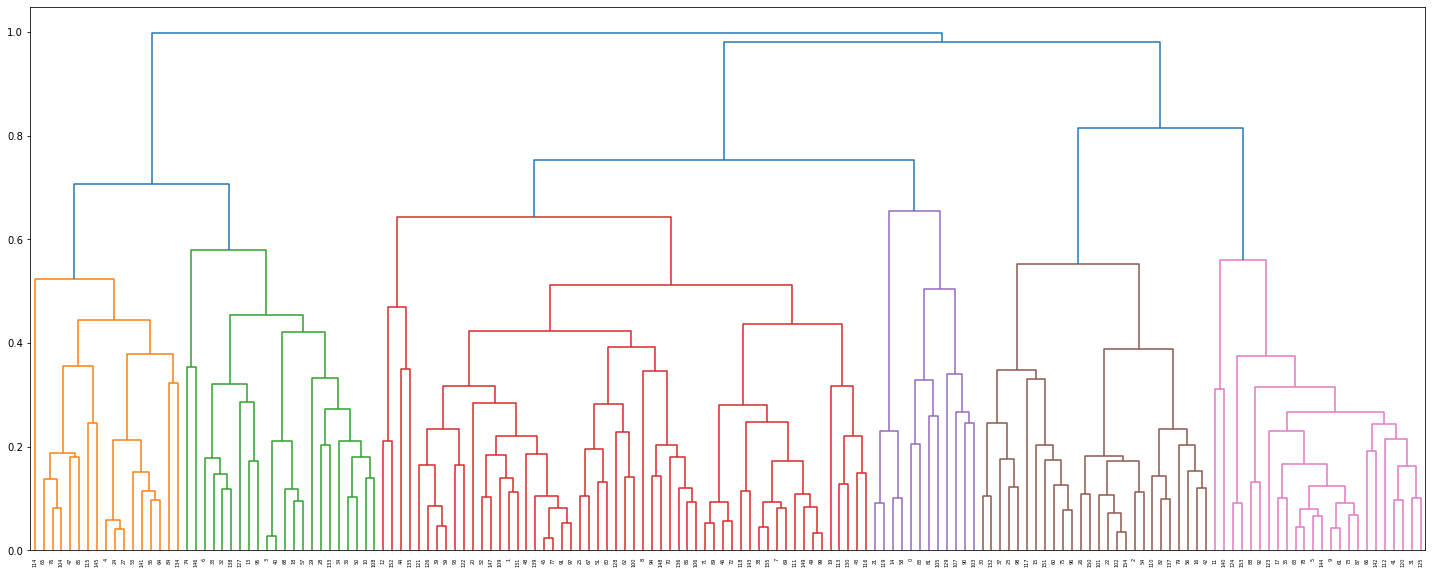

In [71]:
# 시각화
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

In [72]:
# 적당한 개수의 클러스터로 구분
cluster = pd.DataFrame(fcluster(Z,0.6,criterion='distance'))
cluster.columns=['cluster']

In [99]:
champion_df2 = champion_df.sort_values('key', ascending= False).reset_index()
champion_df2

,index,key,name
0,Gwen,887,그웬
1,Lillia,876,릴리아
2,Sett,875,세트
3,Yone,777,요네
4,Pyke,555,파이크
5,Rell,526,렐
6,Aphelios,523,아펠리오스
7,Neeko,518,니코
8,Sylas,517,사일러스
9,Ornn,516,오른


In [100]:
# 결과 DataFrame 구성

# key column 기준 내림차순으로 된 champion_df.name를 cluster 오른쪽에 concat
result = pd.concat([cluster, champion_df2.name] , axis=1)
# result == [cluster | name] 

In [102]:
# 출력
pd.set_option('display.max_rows', None)
result.sort_values(['cluster','name'])

,cluster,name
115,1,갱플랭크
104,1,녹턴
65,1,렝가
145,1,마스터 이
64,1,바루스
141,1,시비르
134,1,애쉬
84,1,이즈리얼
27,1,제드
53,1,제이스
